# **Statistical Tests**

## Objectives

* Perform distribution checks on the data
* Test project hypotheses through statistical tests

## Inputs

* Cleaned data from ETL pipeline

## Outputs

* Outputs are all contained within the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import Data and Load Packages

Load packages required to run the notebook

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Import cleaned data produced by the ETL pipeline

In [12]:
# *Import raw data for testing
# Import cleaned data from ETL pipeline into dataframe

df = pd.read_csv("../data/insurance-cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1337 non-null   int64  
 1   sex           1337 non-null   object 
 2   bmi           1337 non-null   float64
 3   children      1337 non-null   int64  
 4   smoker        1337 non-null   int64  
 5   region        1337 non-null   int64  
 6   charges       1337 non-null   float64
 7   bmi_category  1337 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 83.7+ KB


Convert data types for categorical variables so that they are handled correctly in the code

In [21]:
# convert smoker and region values from number to string
df['smoker'] = df['smoker'].apply(str)
df['region'] = df['region'].apply(str)
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,1,3,16884.92400,Overweight
1,18,male,33.770,1,0,2,1725.55230,Obese
2,28,male,33.000,3,0,2,4449.46200,Obese
3,33,male,22.705,0,0,1,21984.47061,Normal
4,32,male,28.880,0,0,1,3866.85520,Overweight


---

# Initial Visualisations and Distribution Checks

Create simple visulisations for categorical variables

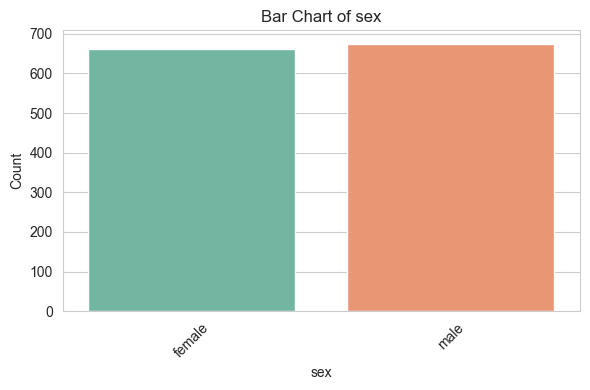

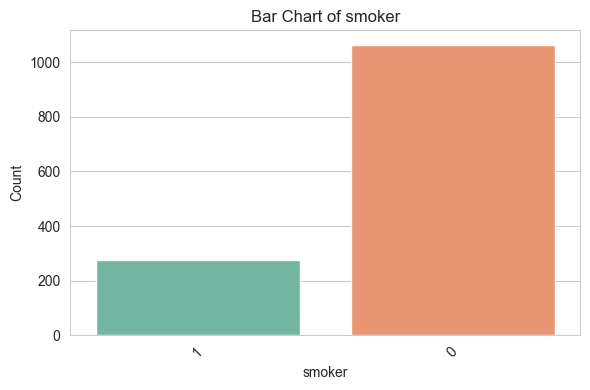

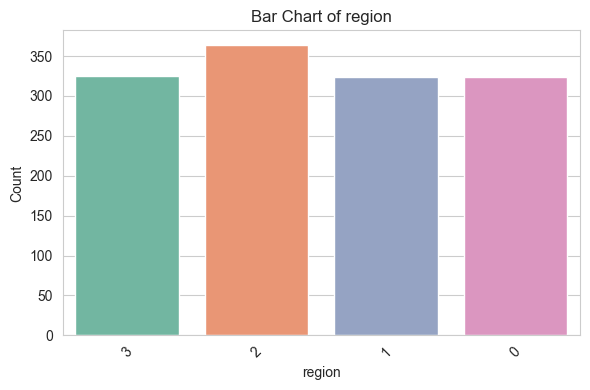

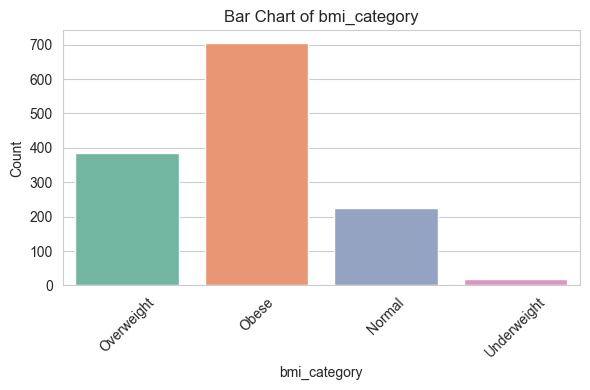

In [27]:
# create a dataframe of categorical columns
df_cat = df.select_dtypes(include='object')

# Loop through each categorical column
for col in df_cat:
    counts = df_cat[col].value_counts()
    
    # ---- Bar chart ----
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df_cat, hue=col, palette="Set2")
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

From these charts we can see that the split of data across different regions and by sex is roughly equal.<br>
BMI category and smoker status are less balanced and we may not be able to accurately predict charges for underrepresented groups in these categories.

Create a histogram of numerical data to visualise distributions

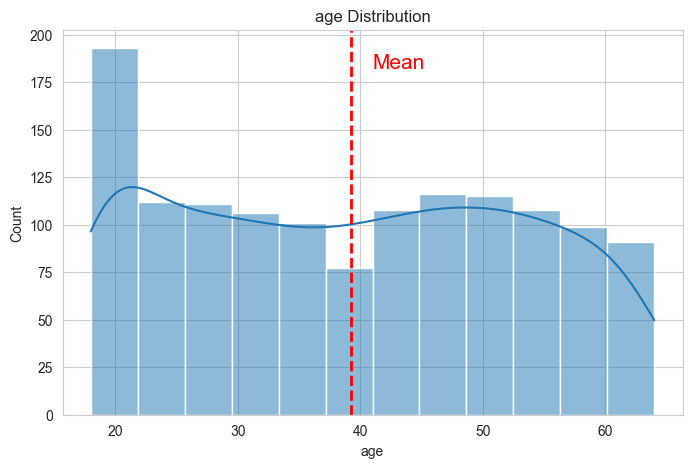

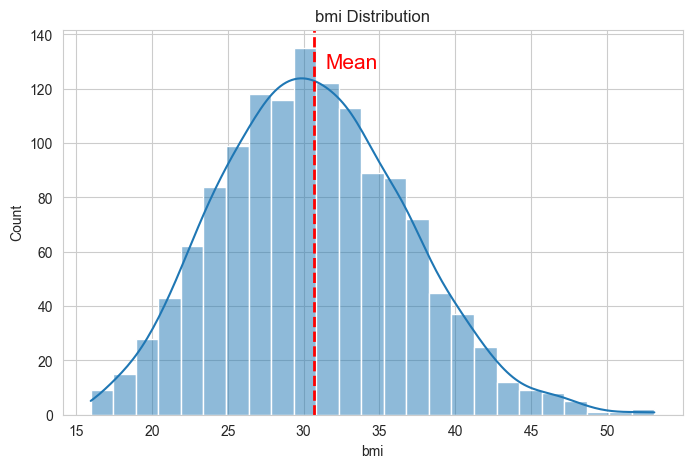

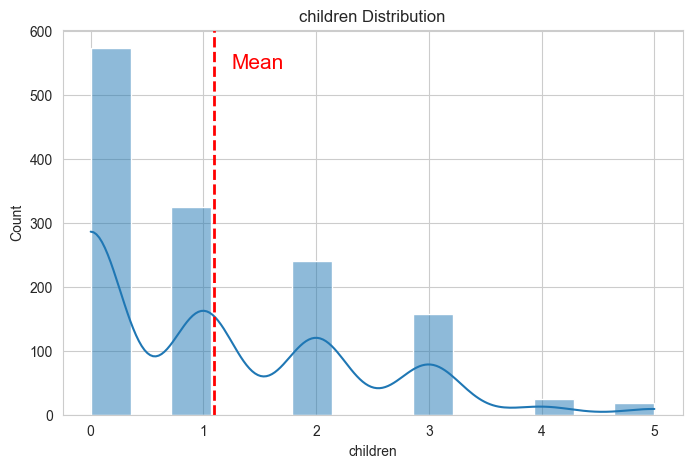

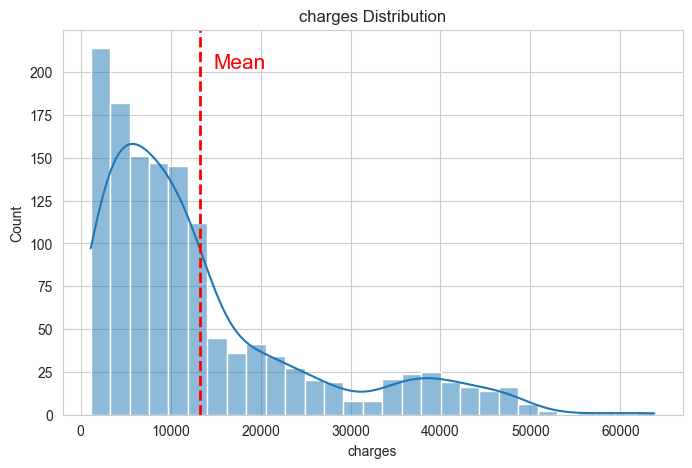

In [ ]:
# create a dataframe of only numeric columns
df_num = df.select_dtypes(include=[np.number])

# loop through numeric columns and create a distribution chart for each
for col in df_num.columns:
  fig, axes = plt.subplots(figsize=(8,5))
  plt.title(f"{col} Distribution")
  sns.histplot(data=df_num, x=col, kde=True)
  plt.axvline(df_num[col].mean(), color='r', linestyle='dashed', linewidth=2)
  plt.text(x=df_num[col].mean() + df_num[col].std()/8 , y=axes.get_ylim()[1] * 0.90, s='Mean', fontsize=15, c='r') # offset mean label
  plt.show()
  print("\n")


---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
